In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import joblib
import subprocess
import polars as pl
import io
import glob
import statsmodels.stats.proportion

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *

In [4]:
rahbari_sample_ids

['PD50477f',
 'PD50519d',
 'PD50508f',
 'PD50523b',
 'PD50521b',
 'PD50508b',
 'PD46180c',
 'PD50521e',
 'PD50489e']

In [5]:
rahbari_df = pl.read_csv("/nfs/users/nfs_r/rs42/rs42/git/sperm/configs/Rahbari.tsv", separator='\t')

In [6]:
output_path = Path("/lustre/scratch122/tol/projects/sperm/results/Rahbari_sequel_only_20250112")

ann_snps_df = pl.concat([
    pl.scan_parquet(glob.glob(str(
        output_path / f"read_analysis/{sample_set}/{sample_id}/*/*/annotated_0.95_high_confidence_snps.parquet"
    ))).with_columns(sample_id=pl.lit(sample_id))
    for sample_id, sample_set in tqdm.tqdm(rahbari_df.select("sample_id", "sample_set").unique().iter_rows())
])
    
ann_snps_df = diagnostics.add_high_quality_annotation(
    ann_snps_df,
    input_column_prefix = "is_high_conf",
    output_column_prefix = "is_high_quality_test",
    phased_coverage_min = 3,
    allele_coverage_min = 3,
    balance_p_value_threshold = 0,
    unassigned_reads_max = 10000,
)

ann_snps_df = (ann_snps_df
    .filter(pl.col("is_high_quality_test_snp"))
)

9it [00:09,  1.04s/it]


In [7]:
coverage_hist = (ann_snps_df
    .group_by("sample_id", "hap1_certainty_0.95_coverage", "hap2_certainty_0.95_coverage")
    .len()
    .collect(streaming=True)
)

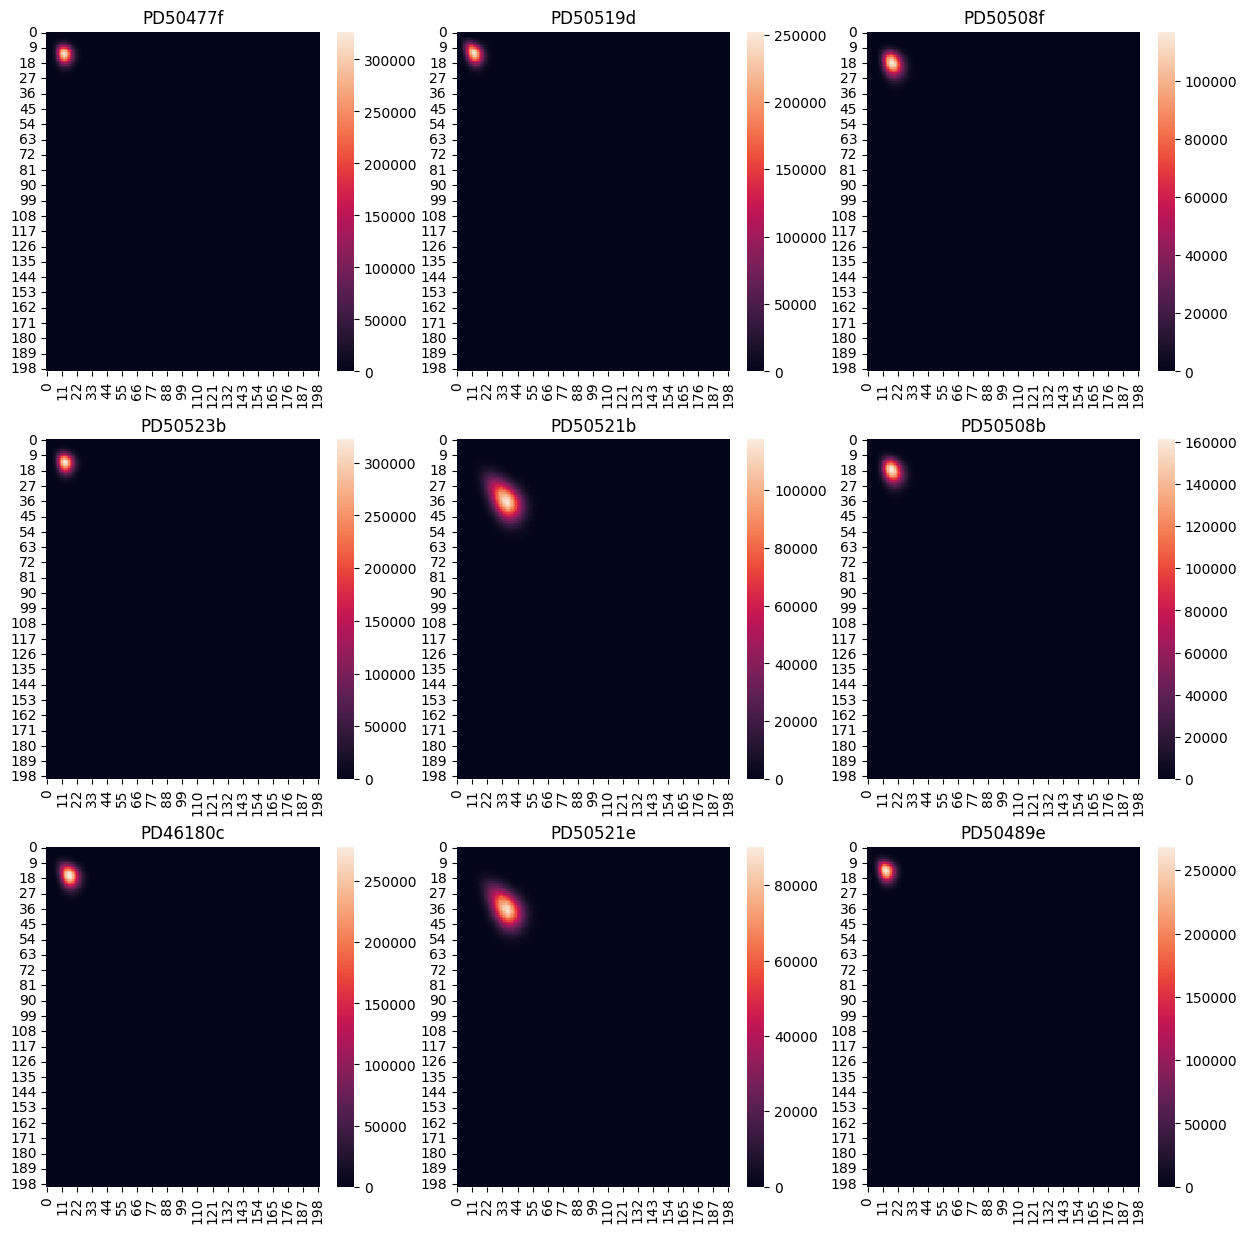

In [8]:
fig, axs = plt.subplots(3,3, figsize=(15, 15));

for sample_id, ax in zip(rahbari_sample_ids, axs.ravel()):
    sub = coverage_hist.filter(pl.col("sample_id") == sample_id)
    A = np.zeros((200, 200))
    A[
        sub["hap1_certainty_0.95_coverage"], 
        sub["hap2_certainty_0.95_coverage"],
    ] = sub["len"]
    sns.heatmap(A[:200,:200], ax=ax);
    ax.set_title(sample_id)


    

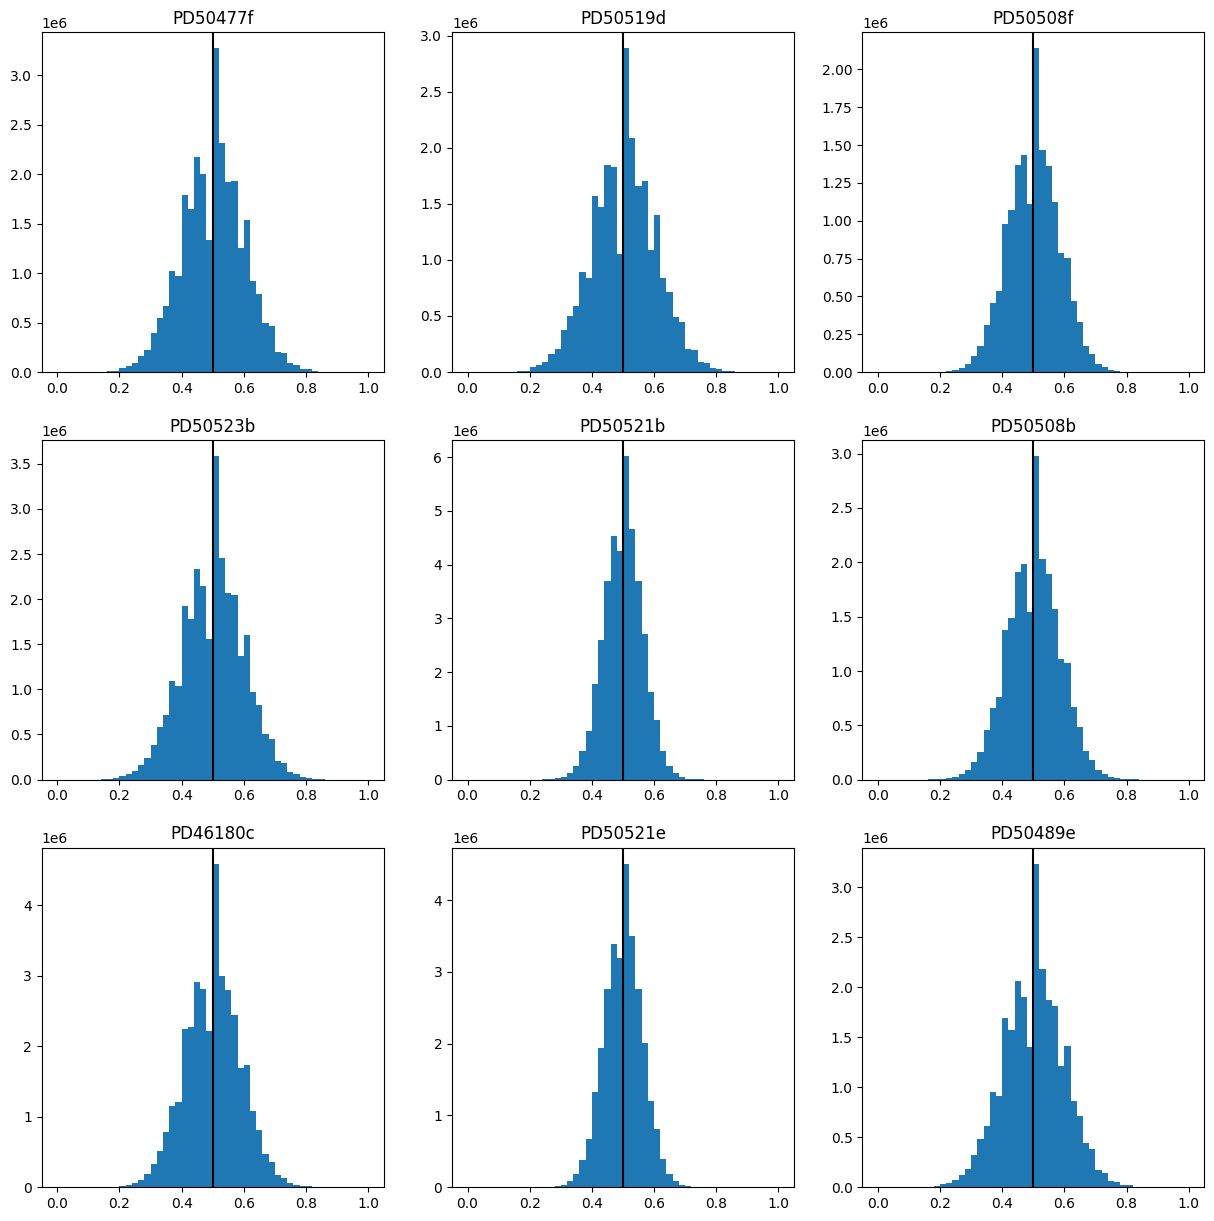

In [9]:
fig, axs = plt.subplots(3,3, figsize=(15, 15));

for sample_id, ax in zip(rahbari_sample_ids, axs.ravel()):
    sub = coverage_hist.filter(pl.col("sample_id") == sample_id)
    A = np.zeros((200, 200))
    A[
        sub["hap1_certainty_0.95_coverage"], 
        sub["hap2_certainty_0.95_coverage"],
    ] = sub["len"]
    x = []
    w = []
    for i in range(200): 
        for j in range(200):
            if i == 0 and j == 0:
                continue
            x.append((i/(i+j)))
            w.append(A[i,j])

    ax.hist(
        x=x, weights=w, bins=50,
    );
    ax.axvline(0.5, color="black");
    ax.set_title(sample_id)


    

In [10]:
%%time
hist_unassigned = (
    ann_snps_df
    .filter((pl.col("hap1_total_coverage") == pl.col("hap2_total_coverage")))
    .with_columns(
         unassigned_reads = (pl.col("hap1_total_coverage") - pl.col("hap1_certainty_0.95_coverage") - pl.col("hap2_certainty_0.95_coverage"))
    )
    .group_by("sample_id", "unassigned_reads")
    .len()
    .collect(streaming=True)
)

CPU times: user 1min 13s, sys: 14 s, total: 1min 27s
Wall time: 2min 19s


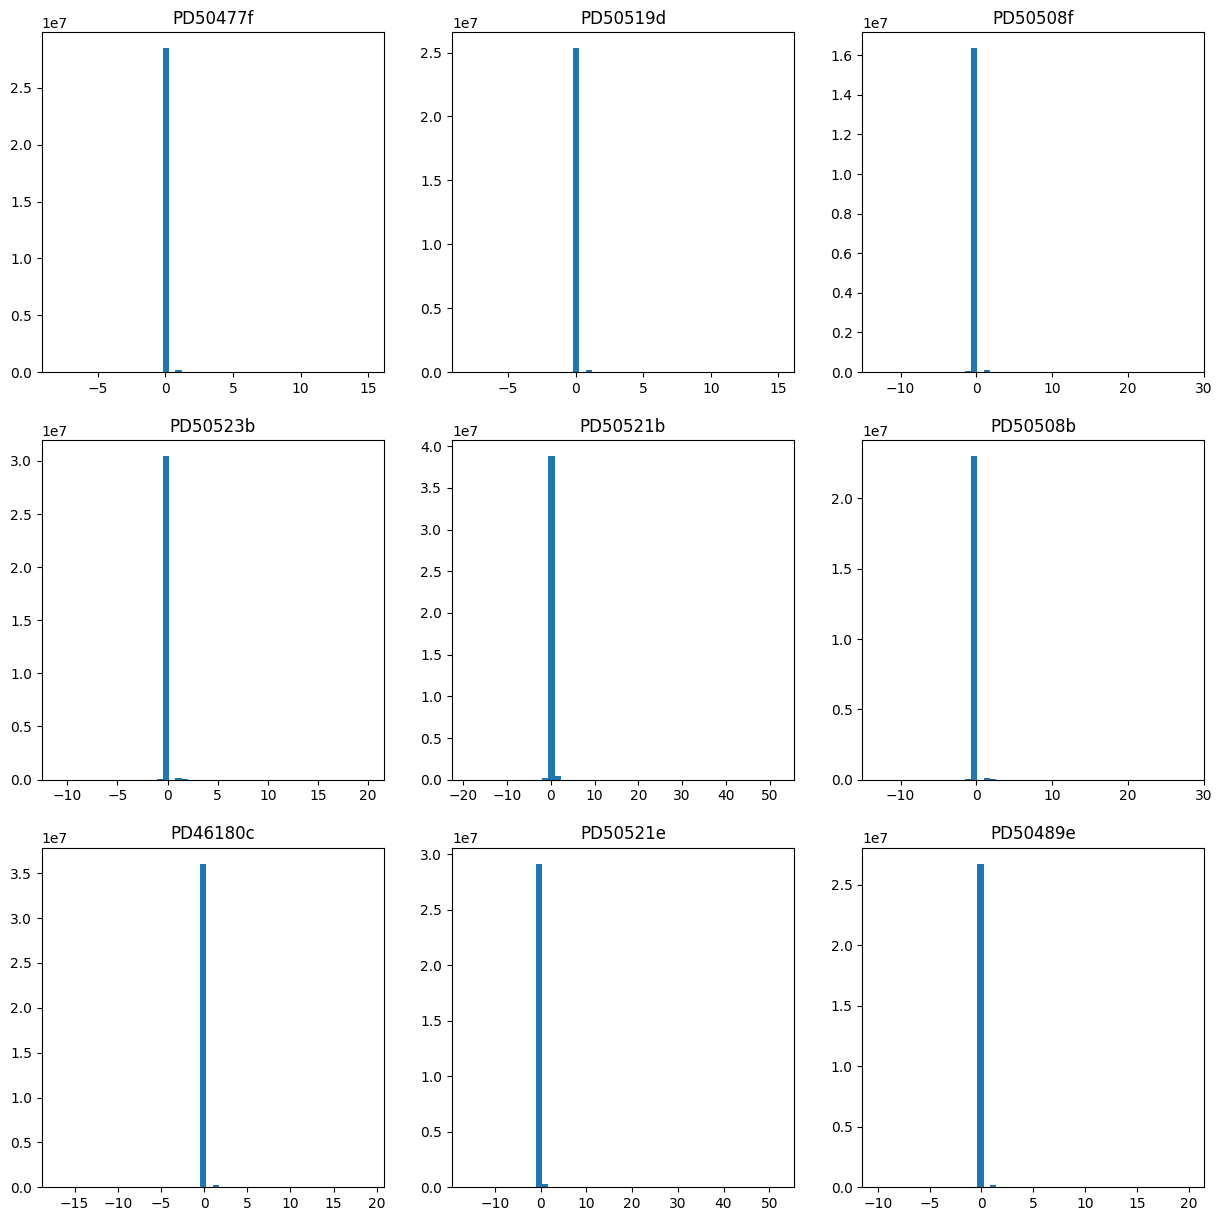

In [11]:
fig, axs = plt.subplots(3,3, figsize=(15, 15));

for sample_id, ax in zip(rahbari_sample_ids, axs.ravel()):
    sub = hist_unassigned.filter(pl.col("sample_id") == sample_id)
    
    x = []
    w = []
    for n, L in zip(sub["unassigned_reads"], sub["len"]):
        x.append(n)
        w.append(L)
   
    ax.hist(
        x=x, weights=w, bins=50,
    );
#    ax.axvline(0.5, color="black");
    ax.set_title(sample_id)


    